# Setup

### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import arviz as az
import cmdstanpy
from cmdstanpy import cmdstan_path, CmdStanModel

#cmdstanpy.install_cmdstan()

### Data

In [14]:
#Load and prepare the covariates, location dummies and housing prices
#For both training and test sets
housing_training_df = pd.read_csv('../data/training_set.csv')
housing_training_df.dropna(inplace = True)

housing_test_df = pd.read_csv('../data/test_set.csv')
housing_test_df.dropna(inplace = True)
#-----------------------------------------------------------------------------------------

#Y
#-----------------------------------------------------------------------------------------
housing_prices_training = housing_training_df['median_hou']
housing_prices_test =     housing_test_df['median_hou'] 
#-----------------------------------------------------------------------------------------

#X
#-----------------------------------------------------------------------------------------
covariate_columns = ['avg_room', 'avg_bedr', 'population',
                     'households', 'median_inc', 'housing_me'] #'ocean_prox'
        
housing_covariates_training = housing_training_df[covariate_columns]
housing_covariates_test =     housing_test_df[covariate_columns] 

#Non-spatial X
non_spatial_covariates = ['avg_bedr', 'population', 'households',
                          'median_inc', 'housing_me']

housing_non_spatial_covariates_training = housing_training_df[non_spatial_covariates]
housing_non_spatial_covariates_test = housing_test_df[non_spatial_covariates]

#Spatial X
spatial_covariates = ['avg_room']

housing_spatial_covariates_training = housing_training_df[spatial_covariates]
housing_spatial_covariates_test = housing_test_df[spatial_covariates]
#-----------------------------------------------------------------------------------------

#Location dummies
#-----------------------------------------------------------------------------------------
location_dummies_training = housing_training_df.loc[:, "Alameda":"Yuba":1]
location_dummies_test =     housing_test_df.loc[:, "Alameda":"Yuba":1]

county_idx_training = np.argmax(location_dummies_training.to_numpy(), axis=1) + 1
county_idx_test = np.argmax(location_dummies_test.to_numpy(), axis=1) + 1
#-----------------------------------------------------------------------------------------

#Ocean dummies
#-----------------------------------------------------------------------------------------
ocean_dummies_training = housing_training_df.loc[:,"<1H OCEAN":"NEAR OCEAN":1]
ocean_dummies_test =     housing_test_df.loc[:,"<1H OCEAN":"NEAR OCEAN":1]
#-----------------------------------------------------------------------------------------

#Turn the data into numpy
#-----------------------------------------------------------------------------------------
ocean_dummies_training = ocean_dummies_training.to_numpy()
location_dummies_training = location_dummies_training.to_numpy()
housing_covariates_training = housing_covariates_training.to_numpy()
housing_prices_training = housing_prices_training.to_numpy()

ocean_dummies_test = ocean_dummies_test.to_numpy()
location_dummies_test = location_dummies_test.to_numpy()
housing_covariates_test = housing_covariates_test.to_numpy()
housing_prices_test = housing_prices_test.to_numpy()

housing_non_spatial_covariates_training = housing_non_spatial_covariates_training.to_numpy()
housing_spatial_covariates_training = housing_spatial_covariates_training.to_numpy()

housing_spatial_covariates_training = housing_spatial_covariates_training.reshape(
    (housing_spatial_covariates_training.shape[0],)
)

housing_non_spatial_covariates_test = housing_non_spatial_covariates_test.to_numpy()
housing_spatial_covariates_test = housing_spatial_covariates_test.to_numpy()

housing_spatial_covariates_test = housing_spatial_covariates_test.reshape(
    (housing_spatial_covariates_test.shape[0],)
)

#Have to make sure that no housing price = 0, therefore add a small buffer
housing_prices_training += 10**(-7) #+ np.abs(housing_prices_training.min())
housing_prices_test += 10**(-7) #+ np.abs(housing_prices_test.min())

def unnormalize(prices):
  return prices * 484101.0 + 14999.0

#Load proximity_matrix from Utils
proximity_matrix = pd.read_csv('../data/W_kernel.csv', delimiter=',')
proximity_matrix = proximity_matrix.to_numpy()

"""# to make the prior on spatial dependence proper we introduce the spatial dependence parameter e
e = 0.99
proximity_matrix = neighbour_matrix * e"""
print(proximity_matrix.shape)

K = housing_covariates_training.shape[1]
N = housing_covariates_training.shape[0]

(58, 58)


# Create and run the model

### Define model

In [4]:
ssvs_stan_model = """
    data {
      int<lower=0> N;   // number of data items
      int<lower=0> K;   // number of predictors 
      matrix[N, K] x;   // predictor matrix
      vector[N] y;      // outcome vector
    }
    
    parameters {
      vector[K] gamma;       // coefficients for predictors
      real<lower=0> tau[K];
      real<lower=0, upper=1> omega[K]; 
      real<lower=0> sigma;
    }
        
    transformed parameters {
      vector[N] mu; // Mean of every house (only as output)
      vector[N] alpha;
      vector[N] beta;
      mu=exp(x*gamma); // Here there is the link function
      beta = mu/sigma;
      for (i in 1:N){
          alpha[i] = mu[i]*beta[i];
      }
      }

    model {
     y ~ gamma(alpha,beta); // The model
   for (i in 1:K){
     target += log_mix(omega[i], 
                    normal_lpdf(gamma[i] | 0, tau[i]*tau[i]),
                    normal_lpdf(gamma[i] | 0, 0.001*tau[i]*tau[i]));
   }
     tau ~ inv_gamma(5,25);
     omega ~ beta(1,1);
     sigma ~ normal(0,5);
      }
"""

### Compile model into stanfile

In [5]:
stan_file = "./ssvs.stan"

with open(stan_file, "w") as f:
    f.write(ssvs_stan_model)

ssvs = CmdStanModel(stan_file=stan_file)

19:39:41 - cmdstanpy - INFO - compiling stan file C:\Users\Achille\OneDrive\ERASMUS\BS\OnlyBayesian\models_notebooks\ssvs.stan to exe file C:\Users\Achille\OneDrive\ERASMUS\BS\OnlyBayesian\models_notebooks\ssvs.exe
19:40:26 - cmdstanpy - INFO - compiled model executable: C:\Users\Achille\OneDrive\ERASMUS\BS\OnlyBayesian\models_notebooks\ssvs.exe
19:40:26 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
19:40:26 - cmdstanpy - WARNING - g++ -std=c++1y -m64 -D_REENTRANT -Wall -Wno-unused-function -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-variable -Wno-sign-compare -Wno-unused-local-typedefs -Wno-int-in-bool-context -Wno-attributes -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.

### Run the model

In [6]:
data = {
    "N": housing_covariates_training.shape[0],
    "K": housing_covariates_training.shape[1],
    "x": housing_covariates_training,
    "y": housing_prices_training,
}

fit = ssvs.sample(data, chains=4, parallel_chains=4, 
                             iter_warmup=2000, iter_sampling=1000)

19:40:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:52:27 - cmdstanpy - INFO - CmdStan done processing.
19:52:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Shape parameter[1] is 0, but must be positive finite! (in 'C:/Users/Achille/OneDrive/ERASMUS/BS/OnlyBayesian/models_notebooks/ssvs.stan', line 28, column 5 to column 27)
	Exception: gamma_lpdf: Shape parameter[1] is 0, but must be positive finite! (in 'C:/Users/Achille/OneDrive/ERASMUS/BS/OnlyBayesian/models_notebooks/ssvs.stan', line 28, column 5 to column 27)
	Exception: gamma_lpdf: Shape parameter[1] is 0, but must be positive finite! (in 'C:/Users/Achille/OneDrive/ERASMUS/BS/OnlyBayesian/models_notebooks/ssvs.stan', line 28, column 5 to column 27)
	Exception: gamma_lpdf: Shape parameter[1] is 0, but must be positive finite! (in 'C:/Users/Achille/OneDrive/ERASMUS/BS/OnlyBayesian/models_notebooks/ssvs.stan', line 28, column 5 to column 27)
	Exception: gamma_lpdf: Shape parameter[1] is 0, but must be positive finite! (in 'C:/Users/Achille/OneD

### Save results (optional)
This will save the results as csv files (1 for each chain) in a specified directory.

In [7]:
save_directory = "./data/ssvs"
fit.save_csvfiles(save_directory)

# Results

In [8]:
# Convert the cmdstanpy file to arviz file
ssvs_az = az.from_cmdstanpy(fit)

### Traceplots

C:\Users\Achille\AppData\Local\Temp\ipykernel_3392\2298020001.py:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


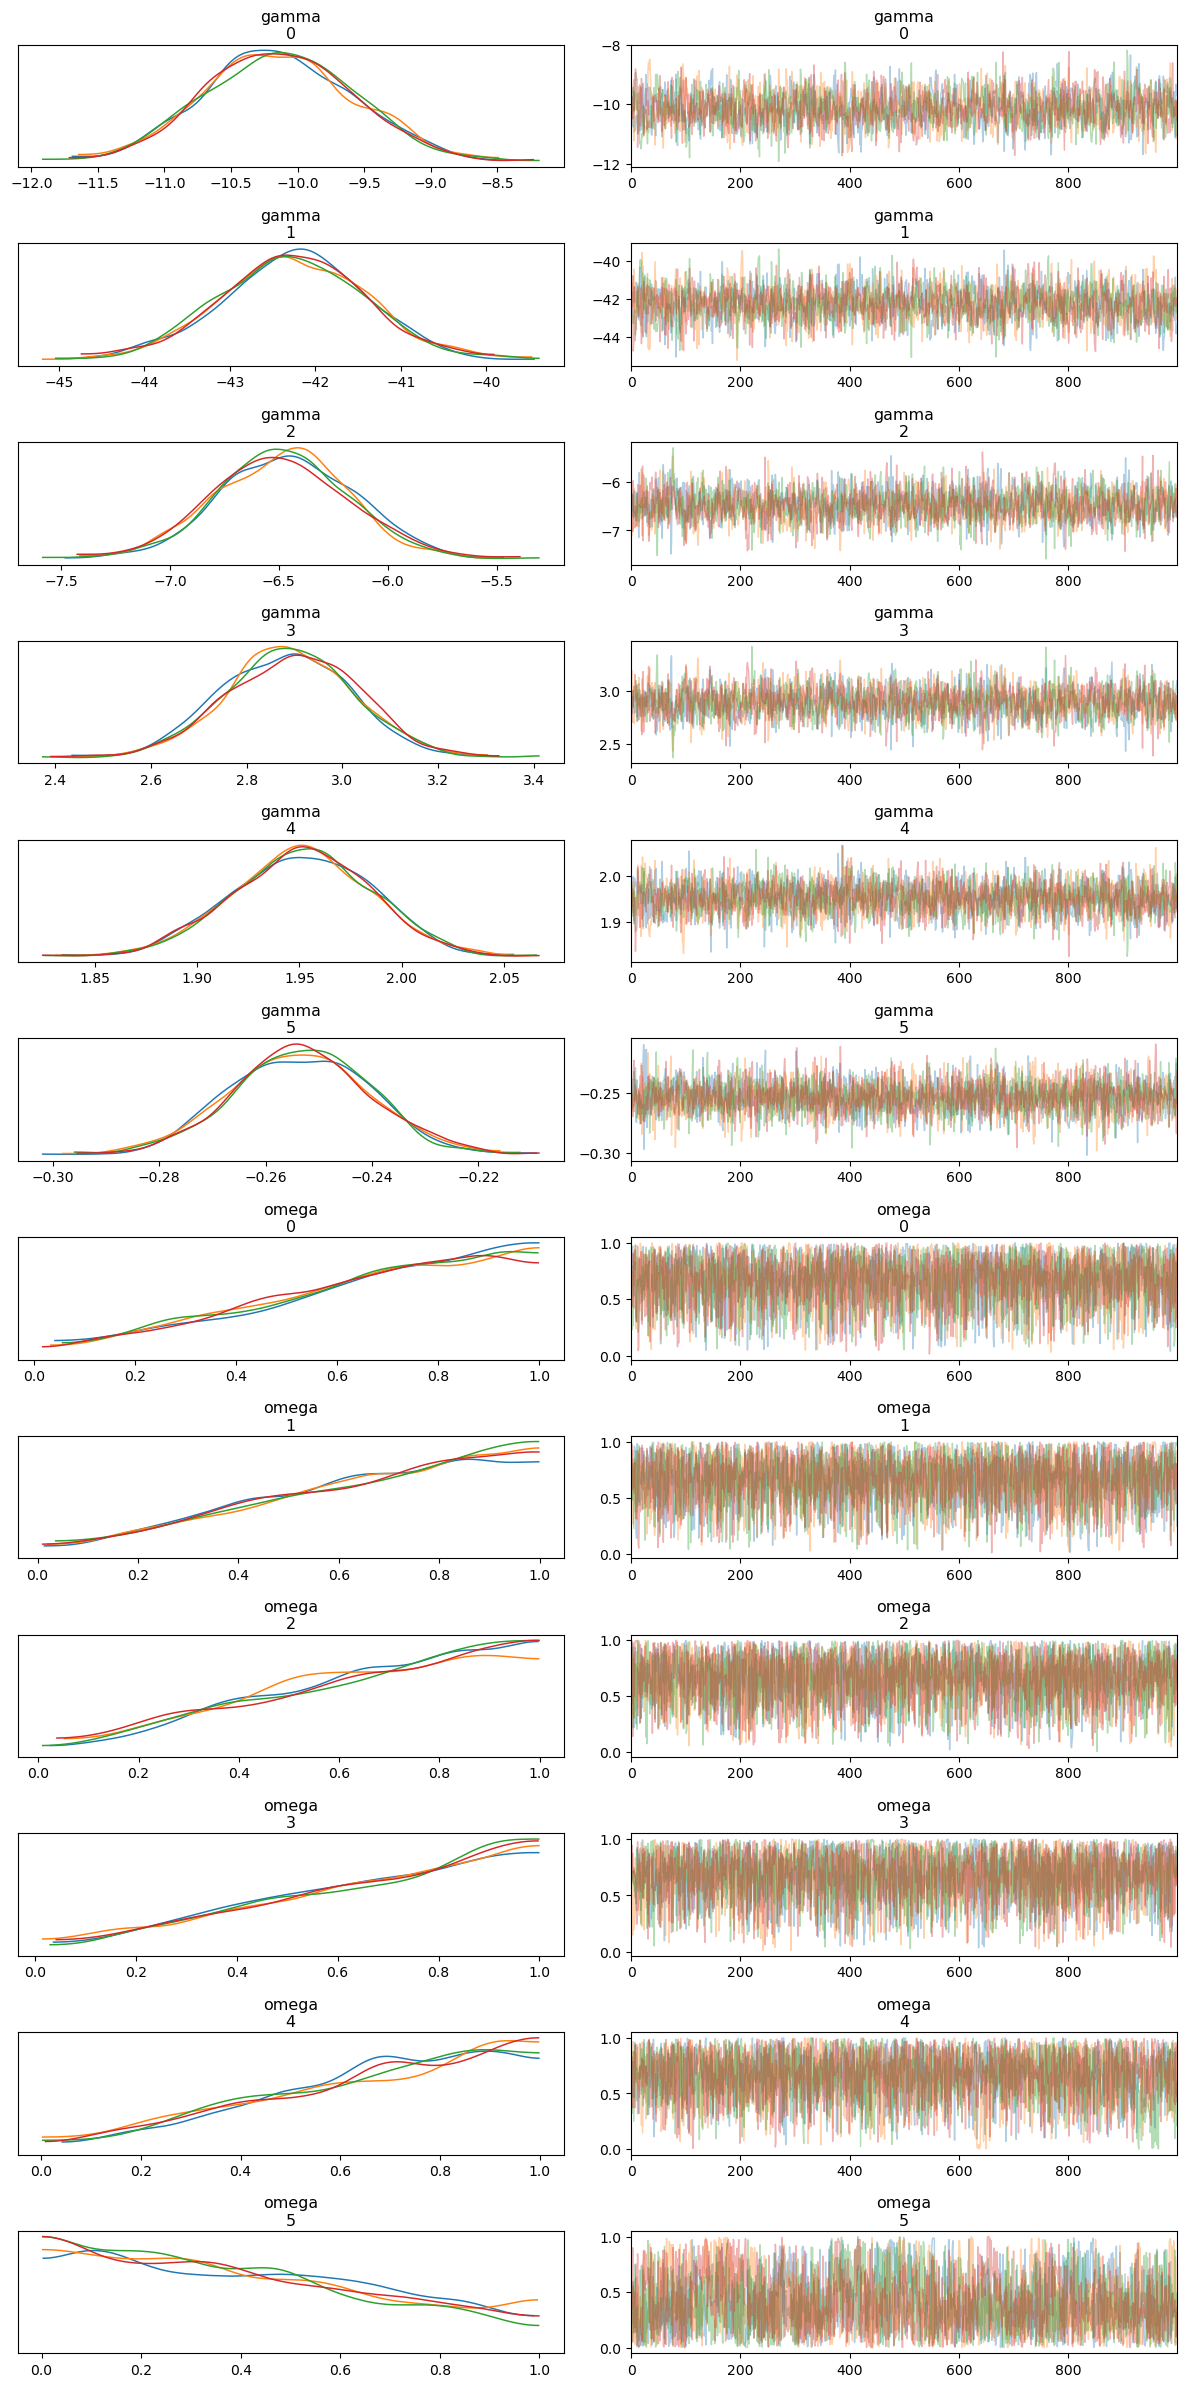

In [9]:
az.plot_trace(fit, var_names=["gamma","omega"], compact=False)
plt.tight_layout()
plt.show()

### Variable selection

In [10]:
summary_df = fit.summary()
omega_df = summary_df["omega[1]":"omega[6]"]
gamma_df = summary_df["gamma[1]":"gamma[6]"]
tau_df = summary_df["tau[1]":"tau[6]"]

In [11]:
Gamma_df = gamma_df["Mean"]
Tau_df = tau_df["Mean"]

In [15]:
def variableselection(Beta,Tau,c):
  c=np.sqrt(c)
  epsilon=np.sqrt(2)*np.sqrt((np.log(np.sqrt(c))*c)/(c-1))
  k=np.zeros(len(Beta))
  variable=k
  k=Tau*epsilon
  for i in range(K):
    if np.abs(Beta[i])>k[i]:
      variable[i]=1
    else:
      variable[i]=0
  return(variable,k,Beta)

In [16]:
variableselection(Gamma_df,Tau_df,0.001)

(array([1., 1., 1., 1., 1., 0.]),
 tau[1]    1.590013
 tau[2]    2.321172
 tau[3]    1.509879
 tau[4]    1.425761
 tau[5]    1.641175
 tau[6]    4.053812
 Name: Mean, dtype: float64,
 gamma[1]   -10.13720
 gamma[2]   -42.25820
 gamma[3]    -6.48004
 gamma[4]     2.88990
 gamma[5]     1.95110
 gamma[6]    -0.25339
 Name: Mean, dtype: float64)